# Evaluation notebook
This notebook visualises **real vs. predicted** results produced by the `train_nfs_kfold.py` 5‑fold cross‑validation run.

It expects the following files in the *current working directory*:
```text
cv_results.csv   # predictions: mf, mf1, mf2, mismatch
data/x_data.csv  # input features  (unused here except for optional inspection)
data/y_data.csv  # ground‑truth target
```
The notebook will draw distribution plots, a Q–Q scatter, residual histograms, and inspect three **example rows** with predicted means around 0.15, 0.30, and 0.001.

> **Note:** All plots use plain matplotlib (no seaborn) as per plotting guidelines.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Make sure plots render inline when the notebook is opened
%matplotlib inline

In [7]:
cv_path   = Path('cv_results.csv')
x_path    = Path('data/x_data.csv')
y_path    = Path('data/y_data.csv')

pred_df = pd.read_csv(cv_path)
y_df    = pd.read_csv(y_path, skiprows=1, names=['y_true'])
x_df    = pd.read_csv(x_path)

# concat

true_df = pd.concat([x_df, y_df], axis=1)


assert len(pred_df) == len(y_df), 'Row counts differ between prediction and ground truth!'

true_df

,mf,mf1,mf2,y_true
0,0.500000,0.100000,0.000625,0.248762
1,0.500000,0.100000,0.000625,0.079721
2,0.500000,0.100000,0.000625,0.066905
3,0.500000,0.100000,0.000625,0.255184
4,0.500000,0.100000,0.000625,0.114864
...,...,...,...,...
1089495,0.190901,0.286092,0.190288,0.365918
1089496,0.190901,0.286092,0.190288,0.306025
1089497,0.190901,0.286092,0.190288,0.506340
1089498,0.190901,0.286092,0.190288,0.611921


## Quick summary

In [ ]:
print('Number of samples:', len(pred_df))
print('\nPrediction columns:')
display(pred_df.head())

print('\nGround‑truth y:')
display(y_df.head())

Number of samples: 1089500

Prediction columns:


,mf,mf1,mf2,mismatch
0,0.137173,-0.000179,0.297280,0.111589
1,0.120763,-0.001247,0.259887,0.041042
2,0.168151,-0.002400,0.322433,0.101245
3,0.146458,-0.012851,0.290516,0.108727
4,0.144616,-0.046197,0.274533,0.029752



Ground‑truth y:


,y_true
0,0.248762
1,0.079721
2,0.066905
3,0.255184
4,0.114864


## Distribution overlap

In [14]:
target = {"mf": 0.15, "mf1": 0.30, "mf2": 0.001}

def find_best_threshold(row):
    a = (row['mf'] - target['mf']) ** 2
    b = (row['mf1'] - target['mf1']) ** 2
    c = (row['mf2'] - target['mf2']) ** 2
    return np.sqrt(a + b + c)


pred_df['best_threshold'] = true_df.apply(find_best_threshold, axis=1)
best_threshold = pred_df['best_threshold'].min()
print(f'Best threshold: {best_threshold:.4f}')
# find best mf, mf1, mf2
best_row = true_df.loc[pred_df['best_threshold'].idxmin()]
print(f"Best mf: {best_row['mf']:.4f}, mf1: {best_row['mf1']:.4f}, mf2: {best_row['mf2']:.4f}")

Best threshold: 0.0223
Best mf: 0.1284, mf1: 0.2967, mf2: 0.0054


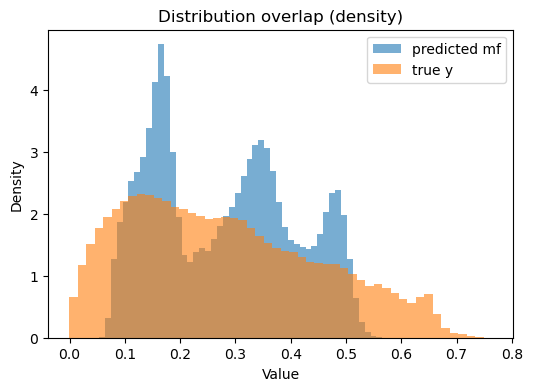

In [ ]:
# Histogram overlay: predicted mean (mf) vs. true y
plt.figure(figsize=(6,4))
plt.hist(pred_df['mf'], bins=50, alpha=0.6, density=True, label='predicted mf')
plt.hist(y_df['y_true'], bins=50, alpha=0.6, density=True, label='true y')
plt.title('Distribution overlap (density)')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Q–Q comparison

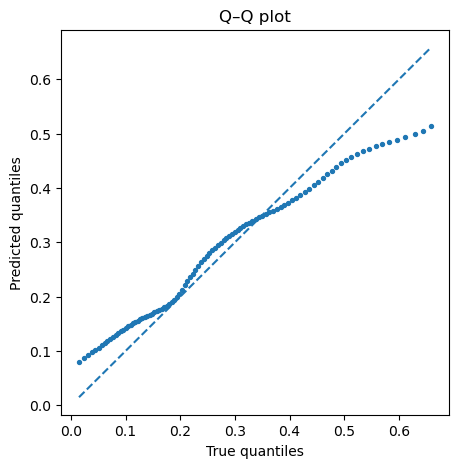

In [ ]:
percs = np.linspace(1, 99, 99)
q_true = np.percentile(y_df['y_true'], percs)
q_pred = np.percentile(pred_df['mf'], percs)

plt.figure(figsize=(5,5))
plt.scatter(q_true, q_pred, s=8)
lims = [min(q_true.min(), q_pred.min()), max(q_true.max(), q_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel('True quantiles')
plt.ylabel('Predicted quantiles')
plt.title('Q–Q plot')
plt.show()

## Residuals (|mf - y_true|)

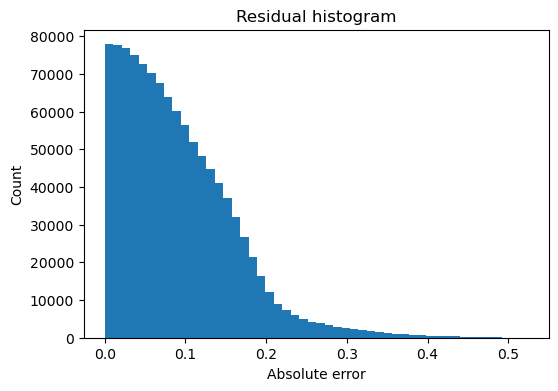

In [ ]:
resid = (pred_df['mf'] - y_df['y_true']).abs()
plt.figure(figsize=(6,4))
plt.hist(resid, bins=50)
plt.xlabel('Absolute error')
plt.ylabel('Count')
plt.title('Residual histogram')
plt.show()

## Three example rows

In [ ]:
wanted = [0.15, 0.30, 0.001]
examples = []
for w in wanted:
    idx = (pred_df['mf'] - w).abs().idxmin()
    examples.append(idx)

example_df = pd.concat([
    pred_df.loc[examples].reset_index(drop=True),
    y_df.loc[examples].reset_index(drop=True)
], axis=1)
example_df

,mf,mf1,mf2,mismatch,y_true
0,0.150000,-0.018749,0.316764,0.082869,0.067131
1,0.300000,0.146640,0.452391,0.089882,0.389882
2,0.053183,0.001253,0.115133,0.024267,0.028915


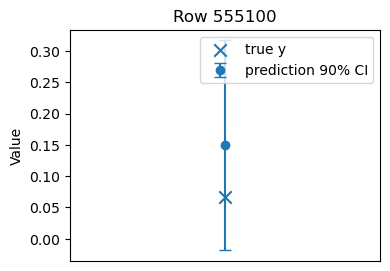

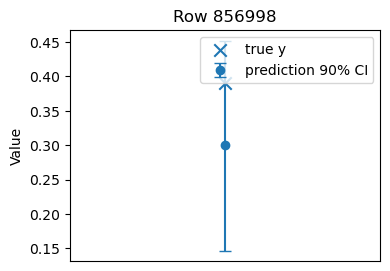

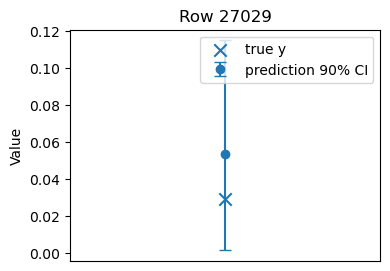

In [ ]:
for i, row in example_df.iterrows():
    plt.figure(figsize=(4,3))
    plt.errorbar(
        x=[0],
        y=[row['mf']],
        yerr=[[row['mf'] - row['mf1']], [row['mf2'] - row['mf']]],
        fmt='o', capsize=4, label='prediction 90% CI')
    plt.scatter(0, row['y_true'], marker='x', s=80, label='true y')
    plt.xticks([])
    plt.ylabel('Value')
    plt.title(f'Row {examples[i]}')
    plt.legend()
    plt.show()